# Cycle CRISP - jeu de données Titanic 

Ce notebook présente l'ensemble du cycle CRISP, sur le jeu de données du Titanic.  

In [972]:
import pandas as pd
import numpy as np
import ipython_memory_usage.ipython_memory_usage as imu
from describe_csv import *  # charge le fichier describe_csv.py par chunk de 10 000 (10**4)
from ydata_profiling import ProfileReport
import math
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import scipy as sp
import scipy.stats
from pivottablejs import pivot_ui
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn import metrics
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split

from sklearn.pipeline import make_pipeline, make_union
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer, make_column_selector
from sklearn.preprocessing import OneHotEncoder, StandardScaler, RobustScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

imu.start_watching_memory()

In [972] used 0.0 MiB RAM in 0.11s (system mean cpu 13%, single max cpu 31%), peaked 0.0 MiB above final usage, current RAM usage now 1015.0 MiB


# 1. Business understanding 

## 1.1 Déterminer les objectifs métiers et analytiques du projet

* objectif métier : gestion des risques, gestion de crise, étudier les comportements humains en cas de survie et améliorer le taux de survie en ayant connaissance du contexte favorable à la survie.
* objectif analytique : prédire la survie d'un passager (algo supervisé de classification : survie ou non, variable à prédire) en fonction de ses caractéristiques individuelles et en fonction de sa situation dans le bateau.

## 1.2. Identifier les contraintes, les limites et les risques du projet :

* disponibilité des données (d'autres données que le Titanic pour étendre le modèle de comportement humain en cas de crise). 

* qualité des données

# 2. Data understanding (compréhension des données)


## 2.1.  Chargement des données

Identifier/collecter/compléter les données nécessaires à la réalisation du projet :

* recenser les sources de données. 

* charger les données pour vous familiariser avec. 

In [849]:
#Chargement incrémental des données
chunks = pd.read_csv("train.csv", delimiter=',', chunksize=100)
chunk_num = 0
for chunk in chunks:              
    df = chunk if chunk_num == 0 else pd.concat([df, chunk]) #reconstruction de df au fur et à mesure, pour vérifier qu'on a bien tout ! juste pour l'exercice
    chunk_num += 1   
    print(chunk_num, end=' ')
df.info()

1 2 3 4 5 6 7 8 9 <class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
In [849] used 0.0 MiB RAM in 0.13s (system mean cpu 12%, single max cpu 54%), peaked 0.0 MiB above final usage, current RAM usage now 978.8 MiB


### Quelle est la taille réelle occupée par le dataframe ?

In [850]:
# méthode pour calculer la taille réelle occupée par le dataframe : les index occupent aussi de la place en mémoire
df.memory_usage(index=True).sum()

85668

In [850] used 0.0 MiB RAM in 0.10s (system mean cpu 13%, single max cpu 67%), peaked 0.0 MiB above final usage, current RAM usage now 978.8 MiB


85668 octets = **0,085668 MB pour le dataframe**  = 85,668 KB

## 2.2 Décrire les données

### Charger les données avec describe_csv et indiquer les types optimaux pour chaque colonne. 

In [851]:
describe_csv("train.csv", delimiter=',')

0 M rows approx.
1 
---------------------------------------------------
train.csv
---------------------------------------------------
            Col     type   min       max nulls optimal type
0   PassengerId    int64     1       891     0        int16
1      Survived    int64     0         1     0         int8
2        Pclass    int64     1         3     0         int8
3          Name   object     -         -     -       object
4           Sex   object     -         -     -       object
5           Age  float64  0.42      80.0   177      float16
6         SibSp    int64     0         8     0         int8
7         Parch    int64     0         6     0         int8
8        Ticket   object     -         -     -       object
9          Fare  float64   0.0  512.3292     0      float16
10        Cabin   object     -         -     -       object
11     Embarked   object     -         -     -       object

 891  rows
In [851] used 0.0 MiB RAM in 0.13s (system mean cpu 24%, single max cpu 10

In [852]:
df.loc[(df.index < 6) | (df.Embarked.isnull())]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0000,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0000,B28,NaN


In [852] used 0.0 MiB RAM in 0.11s (system mean cpu 14%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 978.8 MiB


Catalogue des données: 

Pclass Passenger Class (1 = 1st; 2 = 2nd; 3 = 3rd)
survival Survival (0 = No; 1 = Yes)
name Name
sex Sex
age Age
sibsp Number of Siblings/Spouses Aboard
parch Number of Parents/Children Aboard
ticket Ticket Number
fare Passenger Fare (British pound)
cabin Cabin
embarked Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)
boat Lifeboat
body Body Identification Number
home.dest Home/Destination

### Chargement des données avec types optimaux (sans traiter les valeurs nulles)

In [853]:
# Au final comme le jeu de données n'est pas voluminuex, on aurait pu faire un chargement direct
df = pd.read_csv("train.csv" , dtype = {
              'PassengerId': np.int16,
              'Survived': np.int8,
              'Pclass': np.int8,
              'Name': object,
              'Sex': object,
              'SibSp': np.int8,
              'Parch': np.int8,
              'Ticket': object,
              'Fare': np.float32,
              'Cabin': object,
              'Embarked': object})
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int16  
 1   Survived     891 non-null    int8   
 2   Pclass       891 non-null    int8   
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int8   
 7   Parch        891 non-null    int8   
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float32
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float32(1), float64(1), int16(1), int8(4), object(5)
memory usage: 50.6+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.250000,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.283302,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.925000,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.099998,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.050000,NaN,S


In [853] used 0.0 MiB RAM in 0.12s (system mean cpu 11%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 978.8 MiB


### Nombre de données manquantes par feature

In [854]:
# Vérification des valeurs NULL 
df.isnull().sum() 
# Les colonnes ayant des valeurs nulles sont: Age, Cabin, Embarked. 
# Il faudra traiter ces valeurs nulles plus tard. 

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [854] used 0.0 MiB RAM in 0.11s (system mean cpu 15%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 978.9 MiB


## 2.3 Explorer les données


### Générer un rapport sur les données via Pandas Profiling Report

In [855]:
profile = ProfileReport(df, title='Pandas Profiling Report')
profile.to_file("report-profiling-titanic-dataset.html")
# Si déclenche une erreur : transformer le type de Fare float16 par float32 https://stackoverflow.com/questions/77176780/notimplementederror-float16-indexes-are-not-supported

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [855] used 27.8 MiB RAM in 9.04s (system mean cpu 24%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1006.6 MiB


### Etablir de premières conclusions concernant les données et leurs prétraitements

### Etudier les types de variables statistiques contenus dans le jeu

Regardons les caractéristiques des données du titanic, ce jeu est composé de variables :

 * **Catégorielles / Nominales** (qualitatives) : Variables qui peuvent être divisées en plusieurs catégories mais sans ordre ni priorité. Name est aussi une variable nominale.
     Par exemple : *Embarked* (C = Cherbourg; Q = Queenstown; S = Southampton)
     
     
    
 * **Binaires** (qualitatives) : sous-type d'entités catégorielles, où la variable n'a que deux catégories.
     Par exemple : *Sex* (homme / femme)
     
     
     
 * **Ordinales** (qualitatives) : similaires aux variables catégorielles mais avec un ordre (elles peuvent donc être triées).
     Par exemple : *PClass* (1, 2, 3)
     
     
     
 * **Continues** (quantitatives continues): nombre infini de valeurs (taille, poids…).
     Par exemple : *Age, Fare* (tarif).
     **Nous allons découper en tranches au préalable ces variables numériques.**
     La discrétisation de la variable âge : La discrétisation s'effectue en un groupement par classe d'âge.
     
     
     
 * **Discrètes** (quantitatives) : nombre fini de valeurs (nombre d'enfants dans une famille). Les variables discrètes sont des variables numériques ayant des valeurs dénombrables entre deux valeurs. Une variable discrète est toujours numérique.
     Par exemple : *SibSp, Parch*
     
     
     
 * **Autre** (ID, etc.) : *PassengerID, Ticket et Cabin* contiennent à la fois du texte et des nombres. Ici, le PassengerId, le nom, la cabine et le billet peuvent entrer dans cette catégorie. 
 

On va construire des graphiques nous permettant d'observer les survivants (*Survivors*) / les non-survivants (*Non-Survivors*), en fonction des autres variables.

### 2.3.1 EDA 

Nous allons construire des représentations graphiques nous permettant d'observer les survivants (*Survivors*) / les non-survivants (*Non-Survivors*), en fonction des autres variables.
Effectuer des transformations sur les données pour les besoins de cette analyse exploratoire (pas forcément les mêmes transformations que celles nécessaires lors de l'étape de Feature engineering).

In [856]:
# On commence par traiter les valeurs null de Age (ici on choisit de remplir avec la valeur moyenne)
df['Age'] = df['Age'].fillna(df['Age'].mean())

# On va traiter les valeurs null de cabine et transformer en un champ Boolean (Binaire)
# A une cabine ou non (les valeur NaN de type float sont transformée en 0 pas de cabine. 
# Une interprétation du jeu : pas de valeur = pas de cabine, mais peut-être que la valeur est tt simplement manquante)
df['Cabin'] = np.where(df['Cabin'].isnull(),0, 1)
    
# Nous allons traiter la variable Age : en tranche d'âge --> describe nous dit valeur min: 0.9, max: 80
# On crée une colonne tranche d'age (AgeGroup) par tranche de 10 (voir https://pd.pydata.org/pd-docs/stable/reference/api/pd.cut.html) right=False --> 
# Right= false --> les valeurs maximale de l'ensemble ne sont pas comprises (mais appartiennent à la tranche au dessus)
#range(start, stop, step) --> Create a sequence of numbers from 0 to 81,  increment by 10
df['AgeGroup'] = pd.cut(df.Age, range(0, 81, 10), right=True,\
                        labels=['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80'])  

# Création de tranche de tarifs, par 100
df['FareGroup'] = pd.cut(df.Fare, range(0, 601, 100), right=False, labels=['0-99', '100-199', '200-299', '300-399', '400-499', '500-599'])

    
# On regroupe les données : par survivants/non-survivants
survivors = df[df.Survived == True] #1
non_survivors = df[df.Survived == False] #0


In [856] used -0.9 MiB RAM in 0.12s (system mean cpu 6%, single max cpu 100%), peaked 0.9 MiB above final usage, current RAM usage now 1005.7 MiB


In [857]:
attrs = ['Sex', 'AgeGroup', 'Pclass', 'SibSp', 'Parch', 'Embarked', 'FareGroup']

In [857] used -0.0 MiB RAM in 0.11s (system mean cpu 15%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1005.6 MiB


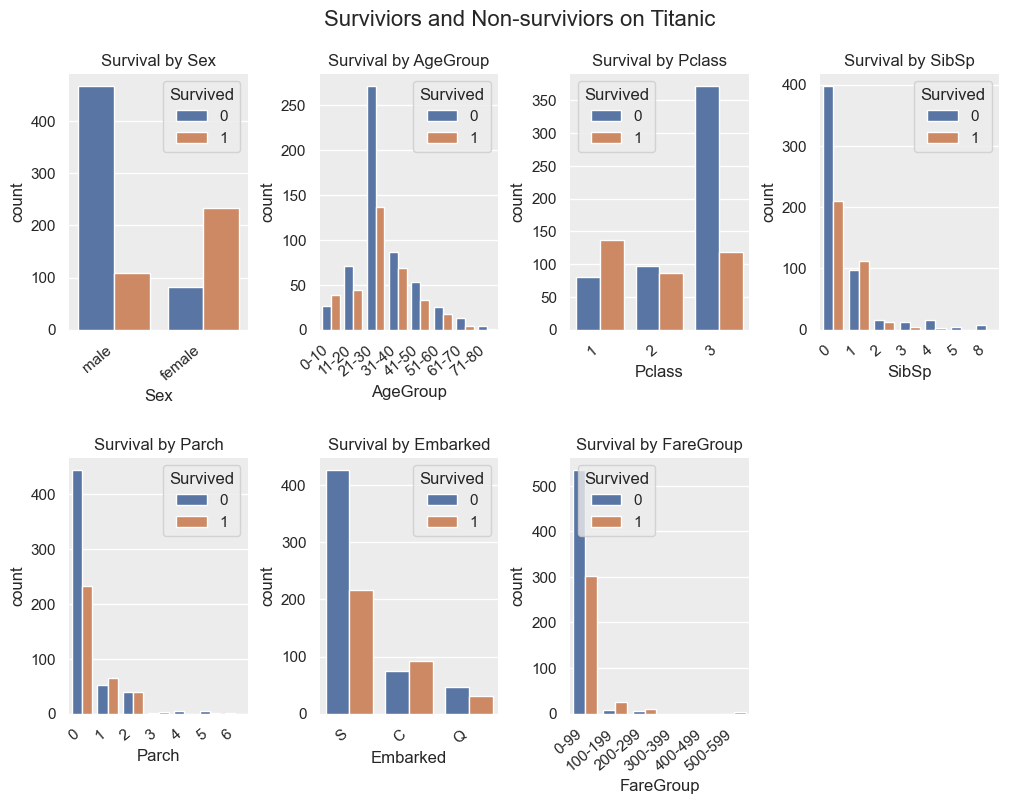

In [858] used 7.4 MiB RAM in 1.16s (system mean cpu 16%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1013.1 MiB


In [858]:
# EDA avec Seaborn
import seaborn as sns
sns.set(style="dark")

figure = plt.figure(figsize = (12, 8))
figure.suptitle('Surviviors and Non-surviviors on Titanic', fontsize=16)
plt.rc('axes', facecolor='#ececec', edgecolor='none', axisbelow=True, grid=True)
plt.rc('grid', color='w', linestyle='solid')
# Add spacing between subplots
plt.subplots_adjust(top = 0.9, bottom=0.1, hspace=0.5, wspace=0.4)

# Plot by Pclass (1)

for i, col in enumerate(attrs):
    plt.subplot(2, 4, i+1)
    plt.xticks(rotation=40, horizontalalignment='right')
    sns.countplot(x=col, hue='Survived', data=df).set_title('Survival by '+col)

plt.show()

Observations :
- chez les femmes, le % de survivants est plus important que chez les hommes
- chez les jeunes enfants, le % de survivants est plus important
- le % de survivants décroît avec la Pclass
- la relation entre SibSp et le % de survivants n'est pas claire
- la relation entre Parch et le % de survivants n'est pas claire
- entre les différents ports d'embarquement, le % de survivants est relativement homogène
- pour les valeurs de Fare les moins élevées, le % de survivants est plus faible



Hypothèses :

   * Sexe : plus de femmes ont survécu que d'hommes
   * Pclass : Les passagers ayant un statut socio-économique plus élevé ont survécu plus que les autres.
   * Age : le jeune passager a survécu plus que les autres passagers.
   * Fare : les passager avec un tarif plus élevé ont survécu plus que les autres passagers. 
    
Conclusions pour les étapes à venir : 

* regarder la corrélation entre Pclass et Fare. 

* Construire un indicateur des deux features SibSp et Parch pour mieux caractériser l'appartenance d'un passager à une famille

* Voir si dans les noms, grâce à des titres (Mr., Sir.), nous pourrions davantage caractériser le statut des passagers. 


### 2.3.1 EDA via pivottablejs

In [859]:
pivot_ui(df)

In [859] used 0.1 MiB RAM in 0.11s (system mean cpu 28%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1013.2 MiB


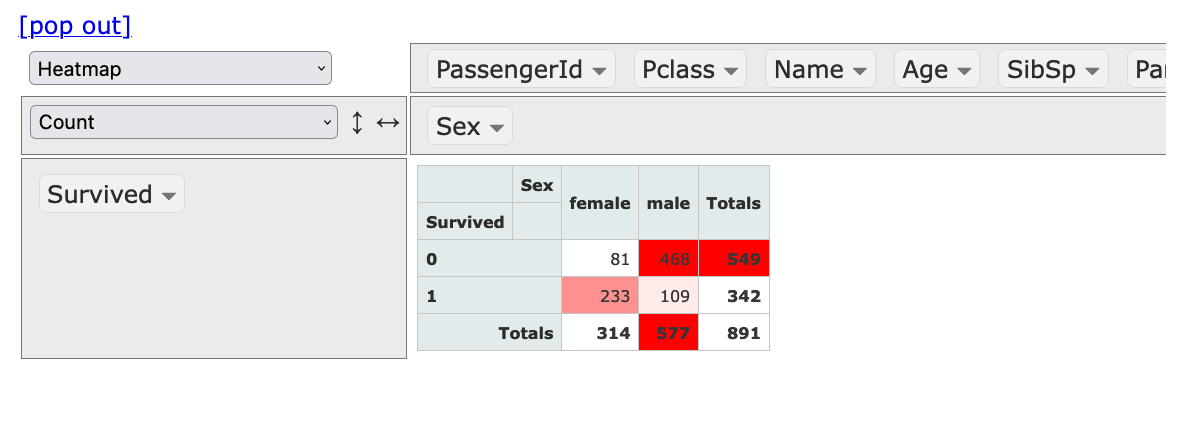

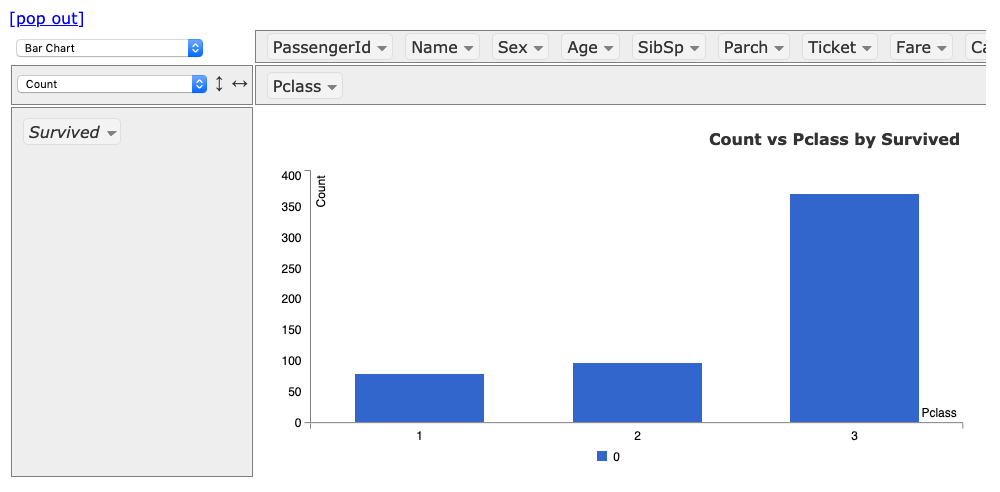

# 3. Préparation des données

## 3.1 Sélectionner les données

### Echantillonnage des données :

* probabiliste : chaque membre de la population a une probabilité égale de figurer dans l’échantillon
* non-probabiliste : chaque membre de la population n'a pas une probabilité égale de figurer dans l’échantillon

Méthodes d'échantillonage vues : 
* Echantillonnage aléatoire simple (probabiliste)
* Echantillonnage stratifié (non-probabiliste)

Faut-il échantillonner les données ? 

In [860]:
df.count()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            891
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          891
Embarked       889
AgeGroup       891
FareGroup      891
dtype: int64

In [860] used 0.1 MiB RAM in 0.11s (system mean cpu 18%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1013.2 MiB


In [861]:
# nb survivants
(df['Survived'] == 1).sum()

342

In [861] used -0.0 MiB RAM in 0.10s (system mean cpu 17%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1013.2 MiB


In [862]:
# nb non survivants
(df['Survived'] == 0).sum()

549

In [862] used -0.0 MiB RAM in 0.10s (system mean cpu 21%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1013.2 MiB


Le jeu de données est suffisamment équilibré, pas besoin d'effectuer un échantillonage stratifié et peu de données, donc pas besoin d'échantillonage.

## 3.2. Nettoyer les données

### 3.2.1. Données manquantes

In [863]:
# A cette étape, on repart à zéro sur le jeu de données, car les traitements fait pour l'EDA était pour la visu. 
df = pd.read_csv("../TD1/jupyter/data/train.csv" , dtype = {
              'PassengerId': np.int16,
              'Survived': np.int8,
              'Pclass': np.int8,
              'Name': object,
              'Sex': object,
              'SibSp': np.int8,
              'Parch': np.int8,
              'Ticket': object,
              'Fare': np.float32,
              'Cabin': object,
              'Embarked': object})

In [863] used 0.0 MiB RAM in 0.11s (system mean cpu 10%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1013.2 MiB


In [864]:
# Vérification des valeurs NULL 
df.isnull().sum() 

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [864] used 0.0 MiB RAM in 0.11s (system mean cpu 10%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1013.2 MiB


#### Traitement des valeurs nulles de la colonne Embarked

Essayez de deviner d'où les passagers avec valeur null à ``embarked`` ont embarqué ? Puis, associer la valeur trouvée aux données manquantes. 

In [865]:
df[df['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


In [865] used -0.0 MiB RAM in 0.11s (system mean cpu 8%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1013.2 MiB


Les PassengerId 62 et 830 ont des valeurs manquantes pour embarked. 

Les deux appartiennent à la classe 1 et le tarif de leur billet est de 80$.

Essayez de deviner d'où ils ont embarqués ? 

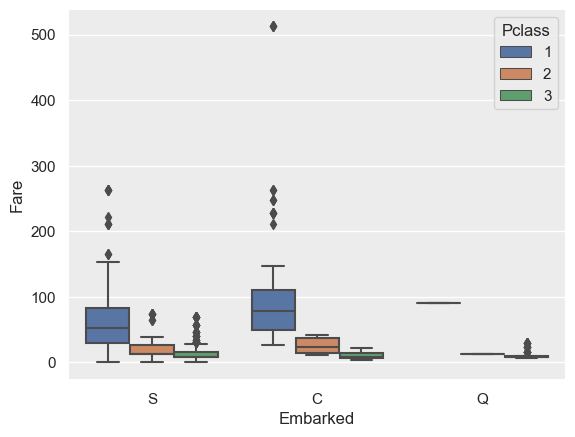

In [866] used 1.5 MiB RAM in 0.32s (system mean cpu 12%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.7 MiB


In [866]:
sns.boxplot(x="Embarked", y="Fare", hue="Pclass", data=df);

Nous pouvons voir que pour la 1ère classe, la ligne médiane se situe autour du tarif de 80$, avec embarquement en «C». Nous pouvons donc remplacer les valeurs NA dans la colonne Embarked par 'C'. 

In [867]:
#df["Embarked"] = df["Embarked"].fillna('C')

In [867] used -0.0 MiB RAM in 0.10s (system mean cpu 10%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.7 MiB


En recherchant dans le Web, on trouve que 
https://github.com/awesomedata/awesome-public-datasets/issues/351

embarked - Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)

et en recherchant par nom dans le web, on trouve une page de description pour ces deux personnes avec la ville d'embarquement : 
https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html --> Embarked: Southampton
https://www.encyclopedia-titanica.org/titanic-survivor/martha-evelyn-stone.html  --> Embarked: Southampton

In [868]:
#df["Embarked"] = df["Embarked"].fillna('S') # plus juste d'après la recherche web

# On va utiliser un imputer 
imputer = SimpleImputer(strategy='constant', fill_value='S')
imputer.fit(df[['Embarked']])
df[['Embarked']] = imputer.transform(df[['Embarked']])

In [868] used 0.0 MiB RAM in 0.11s (system mean cpu 5%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.7 MiB


In [869]:
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [869] used 0.0 MiB RAM in 0.10s (system mean cpu 7%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.7 MiB


#### Traitement des valeurs nulles de la colonne Age

Nous allons utiliser KNN pour estimer au mieux les ages manquants.

In [870]:
# On va utiliser un imputer 
imputerKNN = KNNImputer(n_neighbors=5)
imputerKNN.fit(df[['Age']])
df[['Age']] = imputerKNN.transform(df[['Age']])

In [870] used 0.0 MiB RAM in 0.11s (system mean cpu 8%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.7 MiB


In [871]:
df['Age'].isna().sum()

0

In [871] used 0.0 MiB RAM in 0.11s (system mean cpu 5%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.7 MiB


In [872]:
df.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age              0
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         0
dtype: int64

In [872] used -0.0 MiB RAM in 0.11s (system mean cpu 6%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.7 MiB


In [873]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int16  
 1   Survived     891 non-null    int8   
 2   Pclass       891 non-null    int8   
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int8   
 7   Parch        891 non-null    int8   
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float32
 10  Cabin        204 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float32(1), float64(1), int16(1), int8(4), object(5)
memory usage: 50.6+ KB
In [873] used -0.0 MiB RAM in 0.11s (system mean cpu 7%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.7 MiB


#### Traitement des valeurs nulles de la colonne Cabin

In [874]:
# On va traiter les valeurs nulles de cabine en remplissant Cabin NaN avec U pour unknown 
# TODO utiliser imputer
df['Cabin'] = df.Cabin.fillna('U')

In [874] used 0.0 MiB RAM in 0.11s (system mean cpu 7%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.7 MiB


In [875]:
# On a traité toutes les valeurs nulles
df.isnull().sum() 

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [875] used -0.0 MiB RAM in 0.11s (system mean cpu 8%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.7 MiB


### 3.2.2. Valeurs atypiques (outliers)

Tracer, en un graphique, le boxplot des variables numériques : 

<Axes: >

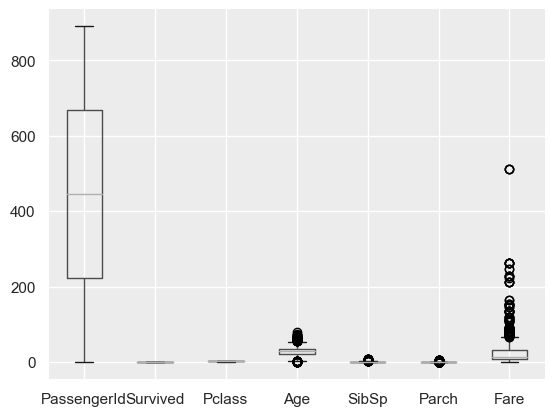

In [876] used 0.0 MiB RAM in 0.94s (system mean cpu 6%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.7 MiB


In [876]:
df.boxplot()

<Axes: >

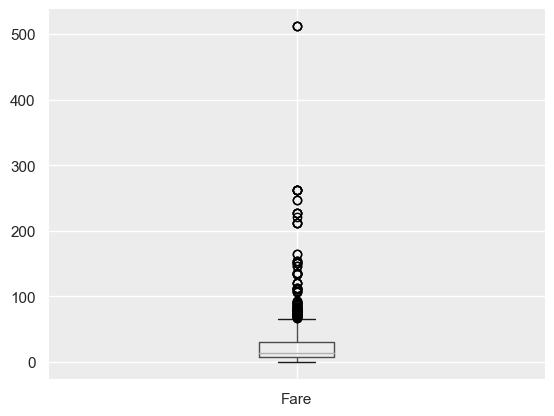

In [877] used 0.0 MiB RAM in 0.20s (system mean cpu 7%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.7 MiB


In [877]:
#Tracer le boxplot de la variable Fare : 
df.boxplot(column='Fare',return_type='axes')

<Axes: >

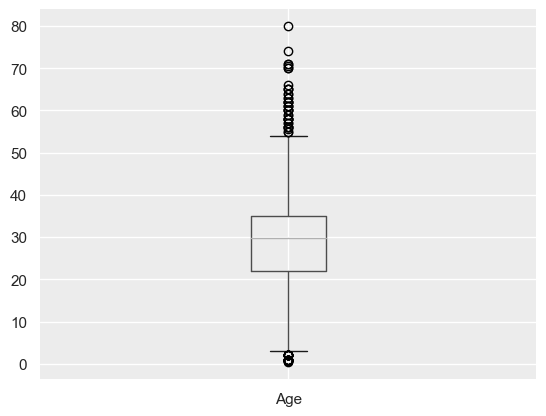

In [878] used 0.0 MiB RAM in 0.22s (system mean cpu 7%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.7 MiB


In [878]:
#Tracer le boxplot de la variable Age : 
df.boxplot(column='Age',return_type='axes')

On va modifier les plus hauts outliers identifiés pour Fare par la valeur du 99ème quantile (247). 

In [879]:
cols = ['Fare']
low = .05
high = .99 #Return values at the given quantile  0.99 (99% quantile)
quant_df =  df[cols].quantile([low, high])
print(quant_df)

            Fare
0.05    7.225000
0.99  249.006218
In [879] used 0.0 MiB RAM in 0.10s (system mean cpu 2%, single max cpu 50%), peaked 0.0 MiB above final usage, current RAM usage now 1014.7 MiB


In [880]:
df[df['Fare'].gt(quant_df.loc[high,'Fare'])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,263.000000,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,263.000000,C23 C25 C27,S
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.329224,U,C
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18.0,2,2,PC 17608,262.375000,B57 B59 B63 B66,C
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,263.000000,C23 C25 C27,S
438,439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,263.000000,C23 C25 C27,S
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.329224,B51 B53 B55,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.329224,B101,C
742,743,1,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21.0,2,2,PC 17608,262.375000,B57 B59 B63 B66,C


In [880] used 0.0 MiB RAM in 0.11s (system mean cpu 3%, single max cpu 67%), peaked 0.0 MiB above final usage, current RAM usage now 1014.8 MiB


In [881]:
higher = quant_df.loc[high,'Fare']
higher

def func(x):
    if x >= higher:
        return higher
    else:
        return x

df['Fare'] = df['Fare'].apply(func)

In [881] used 0.0 MiB RAM in 0.11s (system mean cpu 3%, single max cpu 67%), peaked 0.0 MiB above final usage, current RAM usage now 1014.8 MiB


In [882]:
#vérifier que pour les valeurs les plus hautes, on a bien modifié la valeur de fare par :  	247.66934 	

df[df['Fare'].ge(quant_df.loc[high,'Fare'])]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.0,3,2,19950,249.006218,C23 C25 C27,S
88,89,1,1,"Fortune, Miss. Mabel Helen",female,23.0,3,2,19950,249.006218,C23 C25 C27,S
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,249.006218,U,C
311,312,1,1,"Ryerson, Miss. Emily Borie",female,18.0,2,2,PC 17608,249.006218,B57 B59 B63 B66,C
341,342,1,1,"Fortune, Miss. Alice Elizabeth",female,24.0,3,2,19950,249.006218,C23 C25 C27,S
438,439,0,1,"Fortune, Mr. Mark",male,64.0,1,4,19950,249.006218,C23 C25 C27,S
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,249.006218,B51 B53 B55,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,249.006218,B101,C
742,743,1,1,"Ryerson, Miss. Susan Parker ""Suzette""",female,21.0,2,2,PC 17608,249.006218,B57 B59 B63 B66,C


In [882] used 0.0 MiB RAM in 0.11s (system mean cpu 4%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.8 MiB


<Axes: >

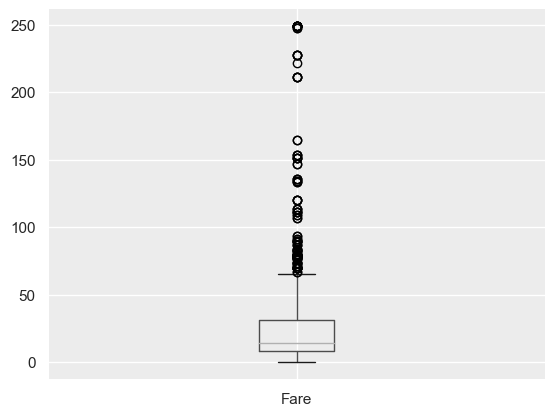

In [883] used 0.0 MiB RAM in 0.21s (system mean cpu 12%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.8 MiB


In [883]:
df.boxplot(column='Fare',return_type='axes')

In [884]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int16  
 1   Survived     891 non-null    int8   
 2   Pclass       891 non-null    int8   
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          891 non-null    float64
 6   SibSp        891 non-null    int8   
 7   Parch        891 non-null    int8   
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        891 non-null    object 
 11  Embarked     891 non-null    object 
dtypes: float64(2), int16(1), int8(4), object(5)
memory usage: 54.1+ KB
In [884] used 0.0 MiB RAM in 0.11s (system mean cpu 10%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.8 MiB


## 3.3 Transformer les données pour améliorer la qualité du modèle

Etape de Feature engineering. 

https://medium.com/i-like-big-data-and-i-cannot-lie/how-i-scored-in-the-top-9-of-kaggles-titanic-machine-learning-challenge-243b5f45c8e9

### 3.3.1 Indépendance des attributs numériques


In [885]:
# effectuer l'encodage du feature Sex (ajouter de colonnes au dataframe) : 
encoder=preprocessing.OneHotEncoder(sparse_output=False)
encoder.fit(df[['Sex']])
columns_name = encoder.get_feature_names_out(['Sex'])
df_encoded = pd.DataFrame(encoder.transform(df[['Sex']]))
df_encoded.columns = columns_name
df= pd.concat([df, df_encoded], axis=1)

In [885] used -0.0 MiB RAM in 0.11s (system mean cpu 5%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.8 MiB


In [886]:
#Observer les corrélations entre les variables numériques dans le jeu :
pd.DataFrame(abs(df.corr(numeric_only=True)['Survived']).sort_values(ascending = False))

,Survived
Survived,1.000000
Sex_male,0.543351
Sex_female,0.543351
Pclass,0.338481
Fare,0.273008
Parch,0.081629
Age,0.069809
SibSp,0.035322
PassengerId,0.005007


In [886] used 0.0 MiB RAM in 0.11s (system mean cpu 10%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.8 MiB


In [887]:
# Conclusion concernant l'indépendance de ces variables numériques ? Traitements nécessaires sur les données ? 

In [887] used 0.0 MiB RAM in 0.11s (system mean cpu 9%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.8 MiB


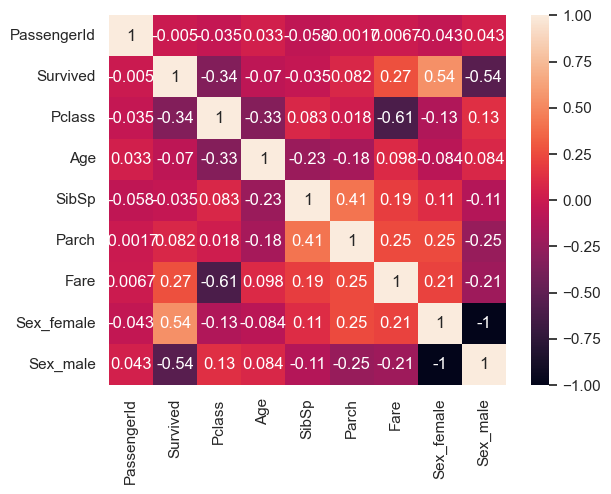

In [888] used 0.0 MiB RAM in 0.44s (system mean cpu 11%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.8 MiB


In [888]:
# NB : on aurait du tester si les variables suivent une loi normale ou non pour choisir le test
# de corrélation le plus adéquat : 
   ## Pearson : pour des données qui suivent une loi normale
   ## kendall et Spearman : dans les autres cas.


#Les collonnes non numériques ne sont pas analysées
corrMatrix = df.corr(numeric_only=True)
sns.heatmap(corrMatrix, annot=True)
plt.show()

Les corrélations entre variables prédictives sont les suivantes : 

* Corrélation (faible) entre Pclass et Age --> on pourrait peut-être se passer de Age, puisque faiblement corrélé à ``Survived`` (tester les résultats sans age)
* Corrélation (faible) entre SibSp et Parch : nous allons créer un seul feature.
* Corrélation (modérée) entre Pclass et Fare (-0,61).

Qui des deux est le plus corrélé avec survived (Pclass ou Fare) ? 
* survived et Pclass : -0.34 
* survived et Fare : 0,27

Ce serait donc Pclass qui devrait être gardé. 
Selon l'analyse de l'importance des attributs, ont décidera ou non de garder cet attribut. 

Remarque : However, no features are significantly corelated (abs(corr) >= 0.75) to be dropped from analysis.

In [889]:
# Un moyen de vérifier cette corrélation: on regarde le prix moyen du billet par Class.

mean = df.groupby(['Pclass'])['Fare'].mean()
mean

Pclass
1    80.114494
2    20.662183
3    13.675550
Name: Fare, dtype: float64

In [889] used 0.0 MiB RAM in 0.11s (system mean cpu 5%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.8 MiB


### 3.3.2 Indépendance des attributs catégoriels

5 variables catégorielles non regardées encore : df.Name, df.Ticket, df.Cabin, df.Embarked, df.Title. 

On va regarder s'il y a corrélation entre : 
* df.Name, df.Ticket, 

* df.Cabin, df.Embarked, 


In [890]:
# entre df.Name, df.Ticket 

ct_cat = pd.crosstab(df.Name, df.Ticket)
ct_cat
chi2, p_value, _, _ = sp.stats.chi2_contingency(ct_cat)
print(chi2, p_value)

605879.9999999998 0.26813798000603034
In [890] used 0.1 MiB RAM in 0.20s (system mean cpu 5%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.9 MiB


__Conclusion__ : p_value > 0.05 : Name et Ticket sont indépendants

In [891]:
# entre df.Cabin, df.Embarked
ct_cat = pd.crosstab(df.Cabin, df.Embarked )
ct_cat
chi2, p_value, _, _ = sp.stats.chi2_contingency(ct_cat)
print(chi2, p_value)

383.3852192048964 0.000343989262187406
In [891] used 0.0 MiB RAM in 0.11s (system mean cpu 5%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.9 MiB


**Conclusion** : p_value < 0.05 : Cabin et Embarked sont dépendants. 
**Il faudra supprimer un des deux par la suite.**

### 3.3.2. Feature engineering

#### Discrétisation des variables numériques continues

Nous allons discrétiser les deux variables : 
* Age 
* Fare 

https://www.kaggle.com/gunesevitan/titanic-advanced-feature-engineering-tutorial

In [893]:
# Pour age, on coupe en fonction de groupe d'age. 
df['Age'] = pd.cut(df['Age'], bins=[0,9,18,35,60,100], right=False)

# Pour fare : par tranche de 50.
df['Fare'] = pd.cut(df.Fare, range(0, 601, 50), right=False)

In [893] used -0.2 MiB RAM in 0.11s (system mean cpu 9%, single max cpu 22%), peaked 0.0 MiB above final usage, current RAM usage now 1014.7 MiB


In [894]:
df.Age.unique()

[[18, 35), [35, 60), [0, 9), [9, 18), [60, 100)]
Categories (5, interval[int64, left]): [[0, 9) < [9, 18) < [18, 35) < [35, 60) < [60, 100)]

In [894] used 0.0 MiB RAM in 0.11s (system mean cpu 19%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.7 MiB


In [895]:
df.Fare.unique()

[[0, 50), [50, 100), [200, 250), [100, 150), [150, 200)]
Categories (12, interval[int64, left]): [[0, 50) < [50, 100) < [100, 150) < [150, 200) ... [400, 450) < [450, 500) < [500, 550) < [550, 600)]

In [895] used 0.0 MiB RAM in 0.11s (system mean cpu 14%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.7 MiB


#### Création de nouveaux features

Nous allons créer 3 features : 

1. Title : Nous allons extraire le titre des passagers du feature "Name".

2. un feature intéressant est la taille de la famille par passager, car le fait d'avoir une famille plus nombreuse peut avoir rendu plus difficile l'obtention d'une place sur un bateau de sauvetage par rapport à un passager seul ou à une petite famille essayant de monter sur un bateau de sauvetage. Nous pouvons exploiter les fonctionnalités SibSp et Parch pour déterminer la taille de la famille, car il s'agit d'un nombre de frères et soeurs / conjoint et parent / enfants respectivement par passager. 

3. Le dernier feature que nous allons créer exploitera la Cabine et extraira simplement la première lettre de la cabine qui détermine dans le bateau, l'emplacement de la section de la cabine. Ceci est potentiellement pertinent car il est possible que certaines cabines aient été plus proches des canots de sauvetage et donc les occupants de ces cabines, qui étaient plus proches des canots, avaient plus de chance d'obtenir une place. 

##### Création de Title
Nous allons extraire le titre des passagers du feature "Name". 

In [896]:
 df.Name

0                                Braund, Mr. Owen Harris
1      Cumings, Mrs. John Bradley (Florence Briggs Th...
2                                 Heikkinen, Miss. Laina
3           Futrelle, Mrs. Jacques Heath (Lily May Peel)
4                               Allen, Mr. William Henry
                             ...                        
886                                Montvila, Rev. Juozas
887                         Graham, Miss. Margaret Edith
888             Johnston, Miss. Catherine Helen "Carrie"
889                                Behr, Mr. Karl Howell
890                                  Dooley, Mr. Patrick
Name: Name, Length: 891, dtype: object

In [896] used 0.0 MiB RAM in 0.11s (system mean cpu 12%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.7 MiB


In [897]:
# create a new feature to extract title names from the Name column https://medium.com/i-like-big-data-and-i-cannot-lie/how-i-scored-in-the-top-9-of-kaggles-titanic-machine-learning-challenge-243b5f45c8e9
# https://stackoverflow.com/questions/45256435/extracting-word-from-a-sentence-using-split-in-python
# La méthode strip() supprime tous les caractères à droite et à gauche (l’espace est le caractère par défaut à supprimer).
df['Title'] = df.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())

df.Title

0        Mr
1       Mrs
2      Miss
3       Mrs
4        Mr
       ... 
886     Rev
887    Miss
888    Miss
889      Mr
890      Mr
Name: Title, Length: 891, dtype: object

In [897] used 0.0 MiB RAM in 0.11s (system mean cpu 11%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.7 MiB


In [898]:
df.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [898] used 0.0 MiB RAM in 0.11s (system mean cpu 12%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.7 MiB


In [899]:
# Nous allons généraliser un peu plus ces 17 différents titres. Voir : https://medium.com/i-like-big-data-and-i-cannot-lie/how-i-scored-in-the-top-9-of-kaggles-titanic-machine-learning-challenge-243b5f45c8e9
normalized_titles = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "the Countess":"Royalty",
    "Lady" :      "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "Mme":        "Mrs", # madame
    "Ms":         "Mrs", # Ms (qui se prononce Miz) veut dire Madame.
    "Mrs" :       "Mrs", # Mrs pour dire Madame. 
    "Mlle":       "Miss", # Miss pour dire mademoiselle.
    "Miss" :      "Miss",
    "Mr" :        "Mr", # Mr pour dire Monsieur. 
    "Master" :    "Master" # Master peut s’utiliser pour un garçon, jusqu’à sa majorité, mais ce titre n’est pas très courant.
}
# map the normalized titles to the current titles 
df.Title = df.Title.map(normalized_titles)

# view value counts for the normalized titles
print(df.Title.value_counts())

Title
Mr         517
Miss       184
Mrs        127
Master      40
Officer     18
Royalty      5
Name: count, dtype: int64
In [899] used 0.0 MiB RAM in 0.11s (system mean cpu 12%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.8 MiB


##### Création de FamilySize

In [900]:
#2- size of families (including the passenger)

#SibSp: Number of siblings/spouses aboard
#Parch: Number of parents/children aboard

df['FamilySize'] = df.Parch + df.SibSp + 1

In [900] used 0.0 MiB RAM in 0.11s (system mean cpu 9%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.8 MiB


##### Création de section dans le bateau

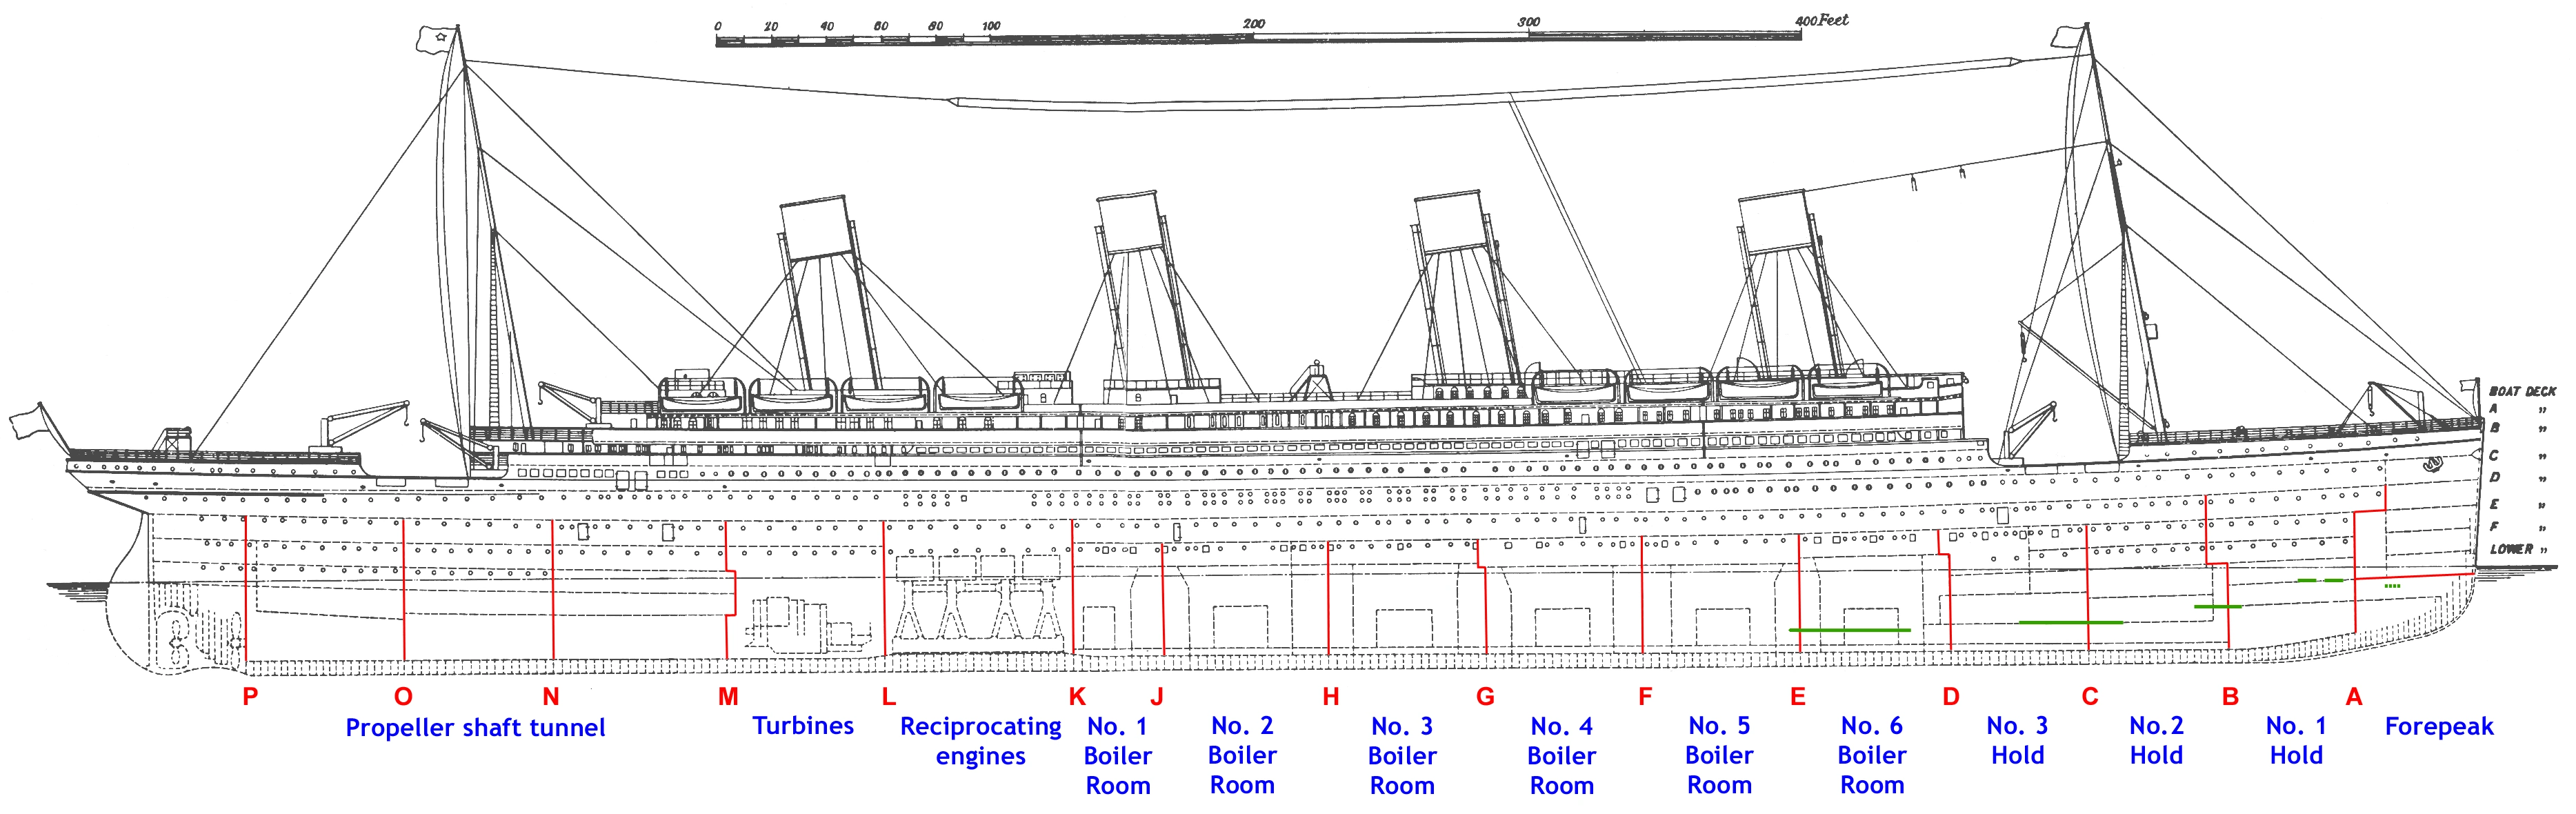

In [901]:
# map first letter of cabin to itself
df.Cabin = df.Cabin.map(lambda x: x[0])

In [901] used 0.0 MiB RAM in 0.11s (system mean cpu 10%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.8 MiB


In [902]:
df.Cabin.unique()

array(['U', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T'], dtype=object)

In [902] used 0.0 MiB RAM in 0.11s (system mean cpu 14%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.8 MiB


In [903]:
df.head(20)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_female,Sex_male,Title,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,"[18, 35)",1,0,A/5 21171,"[0, 50)",U,S,0.0,1.0,Mr,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,"[35, 60)",1,0,PC 17599,"[50, 100)",C,C,1.0,0.0,Mrs,2
2,3,1,3,"Heikkinen, Miss. Laina",female,"[18, 35)",0,0,STON/O2. 3101282,"[0, 50)",U,S,1.0,0.0,Miss,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,"[35, 60)",1,0,113803,"[50, 100)",C,S,1.0,0.0,Mrs,2
4,5,0,3,"Allen, Mr. William Henry",male,"[35, 60)",0,0,373450,"[0, 50)",U,S,0.0,1.0,Mr,1
5,6,0,3,"Moran, Mr. James",male,"[18, 35)",0,0,330877,"[0, 50)",U,Q,0.0,1.0,Mr,1
6,7,0,1,"McCarthy, Mr. Timothy J",male,"[35, 60)",0,0,17463,"[50, 100)",E,S,0.0,1.0,Mr,1
7,8,0,3,"Palsson, Master. Gosta Leonard",male,"[0, 9)",3,1,349909,"[0, 50)",U,S,0.0,1.0,Master,5
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,"[18, 35)",0,2,347742,"[0, 50)",U,S,1.0,0.0,Mrs,3
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,"[9, 18)",1,0,237736,"[0, 50)",U,C,1.0,0.0,Mrs,2


In [903] used 0.0 MiB RAM in 0.12s (system mean cpu 15%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.8 MiB


### 3.3.3 Encodage des attributs discrets/catégoriels

Une étape à effectuer avant de pouvoir commencer notre modélisation est de convertir tous nos features catégoriels en nombres, car nos algorithmes ne peuvent prendre qu'un tableau de nombres en entrée, pas des noms ou des lettres. 
Choisissez les variables à tarnsformer, en utilisant des encoders adaptés. 

Ordinal Encoding pour les variables ordinales (Cabine --> sorte d'ordre dans le bateau) ou les groupes (age, fare). 

On choisit de ne garde pas Embarked car corrélé avec Cabin.

In [904]:
ordinal_encoder = preprocessing.OrdinalEncoder() # Attributs ordinaux

df[['Age', 'Fare']] = ordinal_encoder.fit_transform(df[['Age', 'Fare']])

In [904] used 0.0 MiB RAM in 0.11s (system mean cpu 12%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.8 MiB


In [905]:
# sparse = Will return sparse matrix if set True else will return an array.
encoder=preprocessing.OneHotEncoder(sparse_output=False)
encoder.fit(df[['Cabin']])
columns_name = encoder.get_feature_names_out(['Cabin'])
df_encoded = pd.DataFrame(encoder.transform(df[['Cabin']]))
df_encoded.columns = columns_name
df= pd.concat([df, df_encoded], axis=1)

In [905] used -0.0 MiB RAM in 0.11s (system mean cpu 9%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.8 MiB


In [906]:
# on va traiter title avec un ordre d'importance (grade dans le bateau)

df.Title.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Royalty', 'Officer'], dtype=object)

In [906] used 0.0 MiB RAM in 0.11s (system mean cpu 9%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.8 MiB


In [907]:
def bar_chart(feature):
    survived = df[df['Survived']==1][feature].value_counts()
    dead = df[df['Survived']==0][feature].value_counts()
    df_visu = pd.DataFrame([survived,dead])
    df_visu.index = ['Survived','Dead']
    df_visu.plot(kind='bar',stacked=True, figsize=(10,5))

In [907] used -0.0 MiB RAM in 0.10s (system mean cpu 11%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.8 MiB


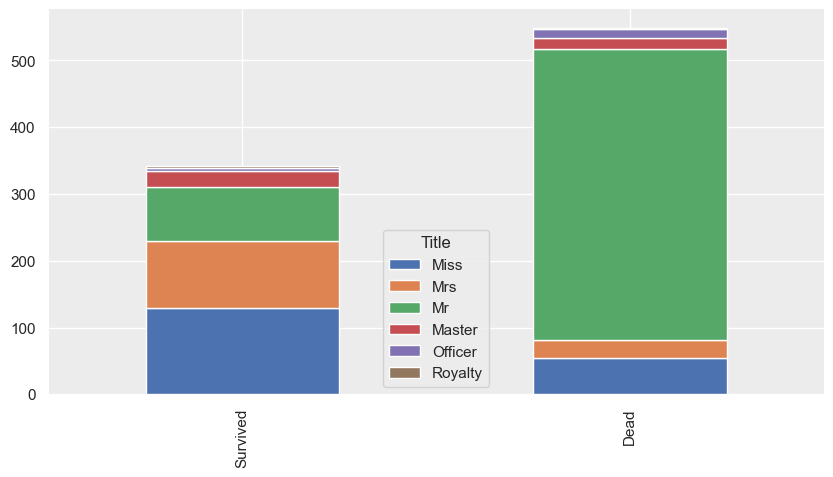

In [908] used 0.0 MiB RAM in 0.30s (system mean cpu 17%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.8 MiB


In [908]:
bar_chart('Title')

In [909]:
print("Survived :\n",df[df['Survived']==1]['Title'].value_counts())
print("Dead:\n",df[df['Survived']==0]['Title'].value_counts())

Survived :
 Title
Miss       129
Mrs        101
Mr          81
Master      23
Officer      5
Royalty      3
Name: count, dtype: int64
Dead:
 Title
Mr         436
Miss        55
Mrs         26
Master      17
Officer     13
Royalty      2
Name: count, dtype: int64
In [909] used 0.0 MiB RAM in 0.11s (system mean cpu 9%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.8 MiB


In [910]:
# L'ordre choisi est en fonction de ceux qui vont le moins survivre, jusqu'à ceux suceptible de survivre le plus.
title_categories = ['Mr', 'Officer', 'Royalty', 'Master', 'Miss', 'Mrs']
enc = preprocessing.OrdinalEncoder(categories=[title_categories])

df['Title'] = enc.fit_transform(df[['Title']])


In [910] used 0.0 MiB RAM in 0.11s (system mean cpu 9%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.8 MiB


In [911]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,...,FamilySize,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,1,0,3,"Braund, Mr. Owen Harris",male,2.0,1,0,A/5 21171,0.0,...,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,3.0,1,0,PC 17599,1.0,...,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,1,3,"Heikkinen, Miss. Laina",female,2.0,0,0,STON/O2. 3101282,0.0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,3.0,1,0,113803,1.0,...,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,0,3,"Allen, Mr. William Henry",male,3.0,0,0,373450,0.0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [911] used 0.0 MiB RAM in 0.13s (system mean cpu 10%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.8 MiB


Supprimer toutes les colonnes non nécessaires par la suite ou déjà retravaillées.

In [912]:
# On enlève tous les features retravaillés et ceux dont nous n'avons pas besoin
# On choisit de ne garde pas Embarked car corrélé avec Cabin.
df.drop(['Embarked', 'Cabin', 'Name', 'Ticket', 'Sex', 'Parch', 'SibSp', 'PassengerId'], axis=1, inplace=True)

df.head()

,Survived,Pclass,Age,Fare,Sex_female,Sex_male,Title,FamilySize,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,0,3,2.0,0.0,0.0,1.0,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,1,3.0,1.0,1.0,0.0,5.0,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,3,2.0,0.0,1.0,0.0,4.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,1,3.0,1.0,1.0,0.0,5.0,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,3,3.0,0.0,0.0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [912] used -0.0 MiB RAM in 0.13s (system mean cpu 13%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.8 MiB


In [913]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Survived,891.0,0.383838,0.486592,0.0,0.0,0.0,1.0,1.0
Pclass,891.0,2.308642,0.836071,1.0,2.0,3.0,3.0,3.0
Age,891.0,2.105499,0.805935,0.0,2.0,2.0,3.0,4.0
Fare,891.0,0.295174,0.769773,0.0,0.0,0.0,0.0,4.0
Sex_female,891.0,0.352413,0.477990,0.0,0.0,0.0,1.0,1.0
Sex_male,891.0,0.647587,0.477990,0.0,0.0,1.0,1.0,1.0
Title,891.0,1.704826,2.100660,0.0,0.0,0.0,4.0,5.0
FamilySize,891.0,1.904602,1.613459,1.0,1.0,1.0,2.0,11.0
Cabin_A,891.0,0.016835,0.128725,0.0,0.0,0.0,0.0,1.0
Cabin_B,891.0,0.052750,0.223659,0.0,0.0,0.0,0.0,1.0


In [913] used 0.0 MiB RAM in 0.15s (system mean cpu 15%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.8 MiB


In [914]:
df.head(20)

,Survived,Pclass,Age,Fare,Sex_female,Sex_male,Title,FamilySize,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U
0,0,3,2.0,0.0,0.0,1.0,0.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1,1,3.0,1.0,1.0,0.0,5.0,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,3,2.0,0.0,1.0,0.0,4.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,1,1,3.0,1.0,1.0,0.0,5.0,2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0,3,3.0,0.0,0.0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
5,0,3,2.0,0.0,0.0,1.0,0.0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6,0,1,3.0,1.0,0.0,1.0,0.0,1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
7,0,3,0.0,0.0,0.0,1.0,3.0,5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,1,3,2.0,0.0,1.0,0.0,5.0,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
9,1,2,1.0,0.0,1.0,0.0,5.0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [914] used -0.0 MiB RAM in 0.14s (system mean cpu 14%, single max cpu 67%), peaked 0.0 MiB above final usage, current RAM usage now 1014.8 MiB


### Importance des attributs

In [915]:
df.info()
df.columns.tolist()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int8   
 1   Pclass      891 non-null    int8   
 2   Age         891 non-null    float64
 3   Fare        891 non-null    float64
 4   Sex_female  891 non-null    float64
 5   Sex_male    891 non-null    float64
 6   Title       891 non-null    float64
 7   FamilySize  891 non-null    int8   
 8   Cabin_A     891 non-null    float64
 9   Cabin_B     891 non-null    float64
 10  Cabin_C     891 non-null    float64
 11  Cabin_D     891 non-null    float64
 12  Cabin_E     891 non-null    float64
 13  Cabin_F     891 non-null    float64
 14  Cabin_G     891 non-null    float64
 15  Cabin_T     891 non-null    float64
 16  Cabin_U     891 non-null    float64
dtypes: float64(14), int8(3)
memory usage: 100.2 KB


['Survived',
 'Pclass',
 'Age',
 'Fare',
 'Sex_female',
 'Sex_male',
 'Title',
 'FamilySize',
 'Cabin_A',
 'Cabin_B',
 'Cabin_C',
 'Cabin_D',
 'Cabin_E',
 'Cabin_F',
 'Cabin_G',
 'Cabin_T',
 'Cabin_U']

In [915] used -0.0 MiB RAM in 0.11s (system mean cpu 21%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.7 MiB


In [916]:
# X_TRAIN
feature_name = [
'Pclass',
 'Age',
 'Fare',
 'Title',
 'Sex_female',
 'Sex_male',
 'FamilySize',
 'Cabin_A',
 'Cabin_B',
 'Cabin_C',
 'Cabin_D',
 'Cabin_E',
 'Cabin_F',
 'Cabin_G',
 'Cabin_T',
 'Cabin_U']
# X_TRAIN
X = df[feature_name]


# Y_TRAIN --> target, variable à prédire
y = df['Survived']

# Entraînement du modèle (n_estimators : The number of trees in the forest.)
forest = RandomForestClassifier(n_estimators=100, n_jobs=-1) # n_jobs=-1 signifie autant de jobs que de coeurs de processeur  
forest.fit(X, y)

RandomForestClassifier(n_jobs=-1)

In [916] used 0.0 MiB RAM in 0.27s (system mean cpu 25%, single max cpu 100%), peaked 0.3 MiB above final usage, current RAM usage now 1014.7 MiB


Importance des attributs d'entrée dans la prédiction "survived":  [0.1166362  0.09024465 0.06000478 0.24025714 0.11460871 0.13448032
 0.1399232  0.00507993 0.01065492 0.00902665 0.00938473 0.01800141
 0.00366945 0.0033335  0.00062946 0.04406494]


Text(0.5, 1.0, 'Importance des attributs')

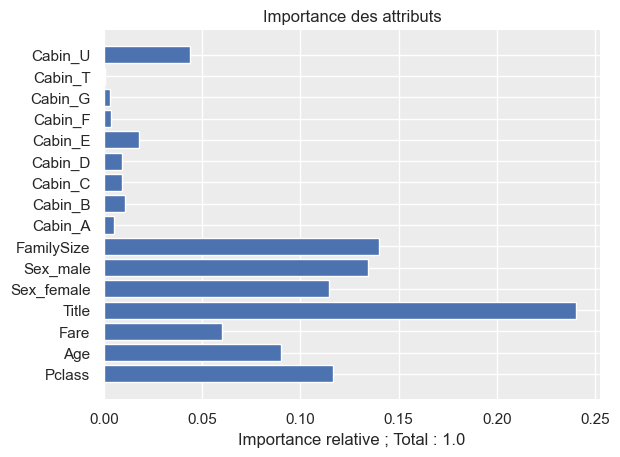

In [917] used 0.0 MiB RAM in 0.38s (system mean cpu 21%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.8 MiB


In [917]:
# Tracer un graphique de l'importance des attributs
%matplotlib inline

importance = forest.feature_importances_
print("Importance des attributs d'entrée dans la prédiction \"survived\": ", importance)

plt.barh(range(len(feature_name)), importance, align='center', tick_label=feature_name)
plt.xlabel('Importance relative ; Total : 1.0')
plt.title('Importance des attributs')

Conclusion : 

On remarque que Title, FamilySize et Sex ont une forte importance dans la prédiction. 

### Réduction de l'ensemble d'attributs


In [918]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)  # supprime les warnings

    
def evalue_modele(model, X_DF, y_DF, n=100):    
    """ 
    model: instance de modèle ; peut être de n'importe quel type : random forest, régression
    X_DF et y_DF: features et targets
    n: nombre de fois où l'on va tester le modèle, pour avoir une évaluation fiable
    Retourne le score moyen
    """

    score = np.empty(n)  # vecteur des n score d'évaluation
    
    for i in range(n):
        
        print('.', end= "") # affichage d'une trace 

        # On prend  2/3 des données pour entraîner le modèle (train), et 1/3 pour tester les prédictions (test)

        X_trainDF, X_testDF, y_trainDF, y_testDF = train_test_split(X, y, test_size=.33)

        model.fit(X_trainDF, y_trainDF)

        # Evaluation : model.score = avec accuracy méthode : nb prédictions correctes / nb predictions --> Return the mean accuracy on the given test data and labels. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier.score
        score[i] = model.score(X_testDF, y_testDF)
    # à la précision 0,0000
    print("Score moyen: ", "{:.4}".format(np.mean(score)))
    return np.mean(score)

In [918] used 0.0 MiB RAM in 0.11s (system mean cpu 13%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.8 MiB


In [919]:
def attribute_to_remove(attrs):

    # on va modifier la liste d'attributs : il faut faire une copie de l'originale

    features = attrs.copy() 

    X_DF = df[features]    # vecteur d'entrée
    y_DF = df['Survived']  # vecteur de sortie

    print("Modele: ", features)
    
    rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
    #n_estimators int, default=100 The number of trees in the forest.
    # n_jobs=-1 signifie autant de jobs que de coeurs de processeur  
    
    
    full_eval = evalue_modele(rf, X_DF, y_DF, n=50)
    #On aura donc 100 arbres construit 50 fois !

    # itération
    max_eval = -np.inf
    candidat_suppression = None
    for i in range(len(features)):

        # suppression de la ieme feature

        remaining_features = features.copy()
        del remaining_features[i]
        print("Elimination de: " + features[i], end=" ")

        # évaluation du modèle correspondant

        X_DF = df[remaining_features]
        
        # On refait tourner le modèle 100 arbres X 20 --> mais un attribut en moins à chaque fois.
        rf = RandomForestClassifier(n_estimators=100, n_jobs=-1)
        eval = evalue_modele(rf, X_DF, y_DF, n=20)

        # mise à jour de l'attribut candidat à la suppression
        # si l'évaluation est la plus haute rencontrée

        if eval > max_eval:
            candidat_suppression = (features[i], "delta: " + "{:.4}".format(eval - full_eval))
            max_eval = eval
    print("\ncandidat à la suppression:", candidat_suppression)

In [919] used 0.0 MiB RAM in 0.11s (system mean cpu 14%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.8 MiB


In [920]:
attribute_to_remove([
'Pclass',
 'Age',
 'Fare',
 'Title',
 'Sex_female',
 'Sex_male',
 'FamilySize',
 'Cabin_A',
 'Cabin_B',
 'Cabin_C',
 'Cabin_D',
 'Cabin_E',
 'Cabin_F',
 'Cabin_G',
 'Cabin_T',
 'Cabin_U'
])

Modele:  ['Pclass', 'Age', 'Fare', 'Title', 'Sex_female', 'Sex_male', 'FamilySize', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_U']
..................................................Score moyen:  0.8155
Elimination de: Pclass ....................Score moyen:  0.82
Elimination de: Age ....................Score moyen:  0.82
Elimination de: Fare ....................Score moyen:  0.8195
Elimination de: Title ....................Score moyen:  0.8217
Elimination de: Sex_female ....................Score moyen:  0.8205
Elimination de: Sex_male ....................Score moyen:  0.8137
Elimination de: FamilySize ....................Score moyen:  0.8171
Elimination de: Cabin_A ....................Score moyen:  0.818
Elimination de: Cabin_B ....................Score moyen:  0.8122
Elimination de: Cabin_C ....................Score moyen:  0.8185
Elimination de: Cabin_D ....................Score moyen:  0.8115
Elimination de: Cabin_E ...............

In [921]:
attribute_to_remove([
 'Pclass',
 'Age',
 'Fare',
 'Title',
 'Sex_female',
 'Sex_male',
 'FamilySize',
 'Cabin_B',
 'Cabin_C',
 'Cabin_D',
 'Cabin_E',
 'Cabin_F',
 'Cabin_G',
 'Cabin_T',
 'Cabin_U'
])

Modele:  ['Pclass', 'Age', 'Fare', 'Title', 'Sex_female', 'Sex_male', 'FamilySize', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_U']
..................................................Score moyen:  0.8204
Elimination de: Pclass ....................Score moyen:  0.8131
Elimination de: Age ....................Score moyen:  0.8222
Elimination de: Fare ....................Score moyen:  0.8147
Elimination de: Title ....................Score moyen:  0.8132
Elimination de: Sex_female ....................Score moyen:  0.818
Elimination de: Sex_male ....................Score moyen:  0.8156
Elimination de: FamilySize ....................Score moyen:  0.8197
Elimination de: Cabin_B ....................Score moyen:  0.8161
Elimination de: Cabin_C ....................Score moyen:  0.8071
Elimination de: Cabin_D ....................Score moyen:  0.8181
Elimination de: Cabin_E ....................Score moyen:  0.8246
Elimination de: Cabin_F ....................Sc

On va s'arrêter ici car le delta est minime. 

In [922]:
# X_TRAIN devient notre dernière liste d'attributs. 
feature_name = [
'Pclass',
 'Age',
 'Fare',
 'Title',
 'Sex_female',
 'Sex_male',
 'FamilySize',
 'Cabin_A',
 'Cabin_B',
 'Cabin_C',
 'Cabin_D',
 'Cabin_E',
 'Cabin_F',
 'Cabin_G',
 'Cabin_T',
 'Cabin_U'
]
# X_TRAIN
X_DF = df[feature_name]


# Y_TRAIN --> target, variable à prédire
y_DF = df['Survived']

In [922] used 0.0 MiB RAM in 0.11s (system mean cpu 10%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.8 MiB


# 4.  Modélisation

## 4.1. Choix du type de modèle

On va tester un RandomForestClassifier. 

## 4.2. Paramétrage du modèle 

### Hyper-paramétrage du modèle 

Arrivé à cette étape, vous avez bien ajusté les features afin de bien coller aux besoins métier et surtout vous les avez affinés afin qu’ils soient mieux pris en compte par l’algorithme de votre choix. 
C’est maintenant lors d’une nouvelle phase d’optimisation que vous allez devoir ajuster l’exécution de l’algorithme de votre choix. En bref, vous aller devoir choisir les hyper-paramètres qui vous donneront le meilleur résultat.

On va utiliser le randomizedSearchCV qui va faire une recherche alléatoire de la meilleure combinaison de valeurs de ces paramètres donnant la meilleure prédiction : réglage du modèle ou model tuning. 

In [923]:
from sklearn.model_selection import RandomizedSearchCV

model = RandomForestClassifier(n_jobs=4) 

params = { 
    "n_estimators": [100, 200, 400, 800],
    "max_features":  [1, 2, 3, 4],
    "max_depth": [3, 4, 5, 6, 7, 8],
    "min_samples_split": [2, 3, 5, 7, 9, 11],
    "min_samples_leaf": [1, 2, 3],
    "criterion": ["gini", "entropy"]
}

rs = RandomizedSearchCV(estimator=model, param_distributions=params, verbose=3, scoring='roc_auc', cv=3)
rs.fit(X_DF, y_DF)
print("Best Params:", rs.best_params_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END criterion=entropy, max_depth=4, max_features=1, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=0.825 total time=   1.5s
[CV 2/3] END criterion=entropy, max_depth=4, max_features=1, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=0.874 total time=   0.5s
[CV 3/3] END criterion=entropy, max_depth=4, max_features=1, min_samples_leaf=2, min_samples_split=5, n_estimators=800;, score=0.886 total time=   0.5s
[CV 1/3] END criterion=entropy, max_depth=3, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=0.825 total time=   0.2s
[CV 2/3] END criterion=entropy, max_depth=3, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=0.872 total time=   0.3s
[CV 3/3] END criterion=entropy, max_depth=3, max_features=2, min_samples_leaf=1, min_samples_split=2, n_estimators=400;, score=0.885 total time=   0.2s
[CV 1/3] END criterion=entr

Dans mon cas,  Best Params: 

`Best Params: {'n_estimators': 800, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 1, 'max_depth': 8, 'criterion': 'entropy'}`

## 4.3. Validation croisée (cross-validation) du modèle

La validation croisée (ou cross-validation  en anglais) est une méthode statistique qui permet d'évaluer la **capacité de généralisation d'un modèle** donc ses performances sur des données jamais vues.

Avec la validation croisée, nous aurons K valeurs de performances sur différentes données de Test, ce qui nous donne une idée approximative de l'intervalle de la performance de notre modèle, une fois qu'il sera soumis à des données qui lui sont inconnues.

La validation croisée s’utilise en une ligne de code en utilisant la fonction cross_val_score qui retourne une liste des précisions obtenues à chaque itération.

In [924]:
# On prend  2/3 des données pour entraîner le modèle (train), et 1/3 pour tester les prédictions (test)
X_trainDF, X_testDF, y_trainDF, y_testDF = train_test_split(X_DF, y_DF, test_size=.33)

In [924] used 0.0 MiB RAM in 0.11s (system mean cpu 12%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1014.9 MiB


In [925]:
# On entraine notre modèle avec les Bests params trouvés précédemment. 
forest = RandomForestClassifier(n_estimators=800, min_samples_split= 5, min_samples_leaf= 3, max_features= 1, max_depth= 8, criterion='entropy',  n_jobs=-1) 

# Apprentissage sur 2/3 (train)
forest.fit(X=X_trainDF, y=y_trainDF)

# Evaluation : prédiction  sur l'autre 1/3 (test)
y_pred = forest.predict(X_testDF) 
y_proba = forest.predict_proba(X_testDF)

#The difference between predict and predict_proba is that predict will give you output like 0,1. 
#Whereas predict_proba will give you the probability value of y being 0 or 1, for each row.

accuracy = metrics.accuracy_score(y_testDF, y_pred)

print("\nExactitude  ", "%.3f" % accuracy)  # The best performance is 1


Exactitude   0.817
In [925] used 0.0 MiB RAM in 1.31s (system mean cpu 11%, single max cpu 100%), peaked 0.3 MiB above final usage, current RAM usage now 1015.0 MiB


In [926]:
# Evaluate a score by cross-validation ; cv--> cross-validation 5 
scores = cross_val_score(forest, X_DF, y_DF, cv=5)

# cross_val_score fait : 
# 1.  la séparation des données pour entraîner le modèle (train) + pour tester les prédictions (test) - réalisé 5X
# 2.  effectue l'apprentissage 5X sur les différents X-Train X-test créés en 1
# 3.  évalue l'apprentissage à chaque fois (5X)

#By default cross_val_score uses the scoring provided in the given estimator, which is usually the simplest appropriate scoring method. 
#E.g. for most classifiers this is accuracy score and for regressors this is r2 score.

scores

array([0.82122905, 0.82022472, 0.82022472, 0.80337079, 0.84831461])

In [926] used 0.2 MiB RAM in 3.93s (system mean cpu 35%, single max cpu 100%), peaked 0.3 MiB above final usage, current RAM usage now 1015.1 MiB


In [927]:
# moyenne des accuracy scores obtenus par cross_val_score (sur différents bouts du jeu de données)
np.mean(scores)

0.8226727763480008

In [927] used 0.0 MiB RAM in 0.11s (system mean cpu 8%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1015.1 MiB


cross_val_score : nous a permis  d’estimer si le modèle choisi est généralisable (et pas sensible à la manière dont on découpe les données). On observe peut de variation dans les scores. 

Le score moyen obtenu n'est pas mauvais : **0.82**

# 5. Evaluation

## Calcul des métriques d'évaluation

In [928]:
print("Matrice de confusion: \n", metrics.confusion_matrix(y_testDF, y_pred, labels=[1, 0]))
print("Exactitude: ", "%.3f" % metrics.accuracy_score(y_testDF, y_pred))
print("Precision: ", "%.3f" % metrics.precision_score(y_testDF, y_pred))
print("Rappel: ","%.3f" %  metrics.recall_score(y_testDF, y_pred))
print("Score F1: ", "%.3f" % metrics.f1_score(y_testDF, y_pred))

Matrice de confusion: 
 [[ 85  29]
 [ 25 156]]
Exactitude:  0.817
Precision:  0.773
Rappel:  0.746
Score F1:  0.759
In [928] used 0.0 MiB RAM in 0.11s (system mean cpu 14%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1015.1 MiB


<Axes: >

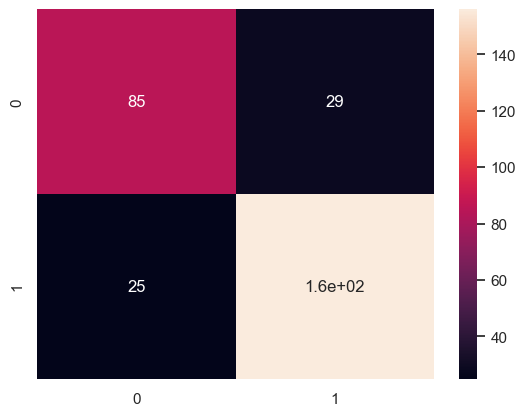

In [929] used 0.0 MiB RAM in 0.31s (system mean cpu 22%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1015.2 MiB


In [929]:
cf_matrix = metrics.confusion_matrix(y_testDF, y_pred, labels=[1,0])
sns.heatmap(cf_matrix, annot=True)

# ordre de l'affichage comme dans le cours avec  labels=[1,0] https://towardsdatascience.com/understanding-the-confusion-matrix-from-scikit-learn-c51d88929c79

Dans le cas du titanic : on veut minimiser le nombre de faux positif (prédire qu'une personne survie alors que non) --> Lorsque vous ne pouvez pas vous permettre d'avoir des faux positifs, vous donnez la priorité à la **précision**.

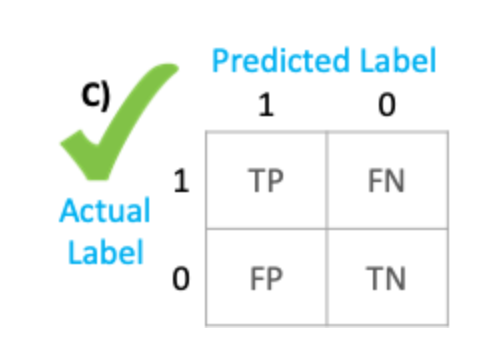

 confusion_matrix(y_test, y_pred, labels=[1,0])

## Affichage de la courbe ROC et de l'AUC

ROC AUC: 0.86


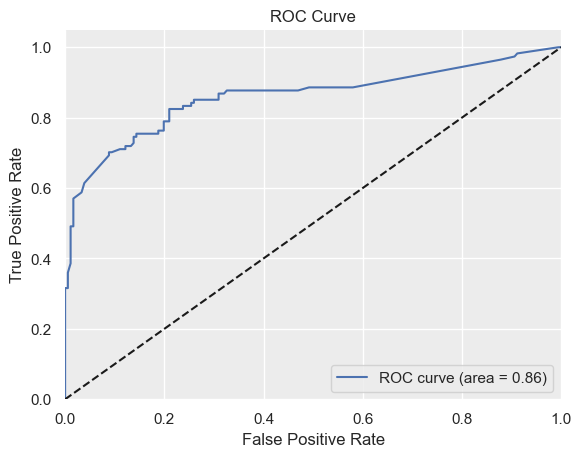

In [930] used 0.0 MiB RAM in 0.30s (system mean cpu 18%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1015.2 MiB


In [930]:
# Determine les taux de faux et vrais positifs
#y_testDF = # ground truth labels
#y_proba = # predicted probabilities generated by sklearn classifier
fpr1, tpr1, s1 = metrics.roc_curve(y_testDF, y_proba[:, 1])

# Calcul de l'AUC
roc_auc1 = metrics.auc(fpr1, tpr1)
print('ROC AUC: %0.2f' % roc_auc1)
 
# Affiche sous forme de courbe
plt.figure()
plt.plot(fpr1, tpr1, label='ROC curve (area = %0.2f)' % roc_auc1)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

Très bon résultats à lire ici : https://www.kaggle.com/mjbhobe/titanic-chance-of-survival-acc-0-97-auc-0-99 

# Second cycle de traitement avec des pipelines

Maintenant que nous connaissons bien le jeu de données, nous pouvons le traiter avec des pipelines, pour éviter la fuite de données et afin de tester plus rapidement différents modèles de classification. 

# 1. Chargement des données 

In [1030]:
df = pd.read_csv("train.csv")

In [1030] used 0.0 MiB RAM in 0.11s (system mean cpu 14%, single max cpu 33%), peaked 0.0 MiB above final usage, current RAM usage now 1015.6 MiB


# 2. Séparation train et test

In [1031]:
X = df.drop(['Survived'], axis=1)
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

In [1031] used 0.0 MiB RAM in 0.11s (system mean cpu 13%, single max cpu 32%), peaked 0.0 MiB above final usage, current RAM usage now 1015.6 MiB


In [1032]:
X_train.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
715,716,3,"Soholt, Mr. Peter Andreas Lauritz Andersen",male,19.0,0,0,348124,7.650,F G73,S
497,498,3,"Shellard, Mr. Frederick William",male,NaN,0,0,C.A. 6212,15.100,NaN,S
92,93,1,"Chaffee, Mr. Herbert Fuller",male,46.0,1,0,W.E.P. 5734,61.175,E31,S
782,783,1,"Long, Mr. Milton Clyde",male,29.0,0,0,113501,30.000,D6,S
748,749,1,"Marvin, Mr. Daniel Warner",male,19.0,1,0,113773,53.100,D30,S


In [1032] used 0.0 MiB RAM in 0.11s (system mean cpu 16%, single max cpu 58%), peaked 0.0 MiB above final usage, current RAM usage now 1015.6 MiB


# 3. Feature Engineering

### Family

In [1033]:
for dataset in [X_train, X_test]:
    dataset['Family_size'] = dataset['Parch'] + dataset['SibSp'] + 1
    dataset.drop(['Parch', 'SibSp'], axis=1, inplace=True)

X_train.head()


,PassengerId,Pclass,Name,Sex,Age,Ticket,Fare,Cabin,Embarked,Family_size
715,716,3,"Soholt, Mr. Peter Andreas Lauritz Andersen",male,19.0,348124,7.650,F G73,S,1
497,498,3,"Shellard, Mr. Frederick William",male,NaN,C.A. 6212,15.100,NaN,S,1
92,93,1,"Chaffee, Mr. Herbert Fuller",male,46.0,W.E.P. 5734,61.175,E31,S,2
782,783,1,"Long, Mr. Milton Clyde",male,29.0,113501,30.000,D6,S,1
748,749,1,"Marvin, Mr. Daniel Warner",male,19.0,113773,53.100,D30,S,2


In [1033] used -0.0 MiB RAM in 0.11s (system mean cpu 14%, single max cpu 34%), peaked 0.0 MiB above final usage, current RAM usage now 1015.6 MiB


### Title

In [1034]:
normalized_titles = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "the Countess":"Royalty",
    "Lady" :      "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "Mme":        "Mrs", # madame
    "Ms":         "Mrs", # Ms (qui se prononce Miz) veut dire Madame.
    "Mrs" :       "Mrs", # Mrs pour dire Madame. 
    "Mlle":       "Miss", # Miss pour dire mademoiselle.
    "Miss" :      "Miss",
    "Mr" :        "Mr", # Mr pour dire Monsieur. 
    "Master" :    "Master" # Master peut s’utiliser pour un garçon, jusqu’à sa majorité, mais ce titre n’est pas très courant.
}


for dataset in [X_train, X_test]:
  dataset['Title'] =  dataset['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
    # map the normalized titles to the current titles 
  dataset['Title'] = dataset.Title.map(normalized_titles)
  dataset.drop(["Name"], axis=1, inplace=True)

X_train.head()


,PassengerId,Pclass,Sex,Age,Ticket,Fare,Cabin,Embarked,Family_size,Title
715,716,3,male,19.0,348124,7.650,F G73,S,1,Mr
497,498,3,male,NaN,C.A. 6212,15.100,NaN,S,1,Mr
92,93,1,male,46.0,W.E.P. 5734,61.175,E31,S,2,Mr
782,783,1,male,29.0,113501,30.000,D6,S,1,Mr
748,749,1,male,19.0,113773,53.100,D30,S,2,Mr


In [1034] used 0.0 MiB RAM in 0.12s (system mean cpu 15%, single max cpu 29%), peaked 0.0 MiB above final usage, current RAM usage now 1015.6 MiB


### Suppression de colonnes 


Pour simplifier la suite des traitements, on supprime les colonnes Ticket et Cabin

In [1035]:
for dataset in [X_train, X_test]:
  dataset.drop('Ticket', axis=1, inplace=True)
  dataset.drop('Cabin', axis=1, inplace=True)
  dataset.drop('PassengerId', axis=1, inplace=True)

In [1035] used 0.0 MiB RAM in 0.11s (system mean cpu 15%, single max cpu 37%), peaked 0.0 MiB above final usage, current RAM usage now 1015.6 MiB


# 4. Imputation de Valeur manquantes et encodage 

In [1036]:
X_train.isnull().sum()

Pclass           0
Sex              0
Age            124
Fare             0
Embarked         2
Family_size      0
Title            0
dtype: int64

In [1036] used 0.0 MiB RAM in 0.11s (system mean cpu 18%, single max cpu 36%), peaked 0.0 MiB above final usage, current RAM usage now 1015.6 MiB


In [1037]:
X_test.isnull().sum()

Pclass          0
Sex             0
Age            53
Fare            0
Embarked        0
Family_size     0
Title           0
dtype: int64

In [1037] used 0.0 MiB RAM in 0.11s (system mean cpu 25%, single max cpu 50%), peaked 0.0 MiB above final usage, current RAM usage now 1015.6 MiB


### Variables catégorielles

In [1038]:
cat_cols = ['Embarked', 'Sex', 'Title', 'Pclass' ]

In [1038] used 0.0 MiB RAM in 0.11s (system mean cpu 17%, single max cpu 33%), peaked 0.0 MiB above final usage, current RAM usage now 1015.6 MiB


In [1039]:
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

In [1039] used 0.0 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 1015.6 MiB


### Variables numériques

In [1040]:
num_cols = ['Age', 'Fare', 'Family_size']
num_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])

In [1040] used 0.0 MiB RAM in 0.10s (system mean cpu 11%, single max cpu 27%), peaked 0.0 MiB above final usage, current RAM usage now 1015.6 MiB


### Column transformers

In [1041]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('cat', cat_transformer, cat_cols)
    ])

In [1041] used 0.0 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 1015.6 MiB


# 5. Cross Validation

In [1042]:
clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', RandomForestClassifier())])

cross_val_score(clf, X_train, y_train, cv=5, scoring="accuracy").mean()

0.8138655462184874

In [1042] used 0.0 MiB RAM in 0.80s (system mean cpu 16%, single max cpu 62%), peaked 0.0 MiB above final usage, current RAM usage now 1015.6 MiB


# 6. Hyper-parameters

In [1043]:
num_transformer_dist = {'preprocessor__num__imputer__n_neighbors': list(range(2, 15))}

cat_transformer_dist = {'preprocessor__cat__imputer__strategy': ['most_frequent', 'constant']}

random_forest_dist = {'classifier__n_estimators': list(range(50, 500)),
                      'classifier__max_depth': list(range(2, 20))}

param_dist = {**num_transformer_dist, **cat_transformer_dist, **random_forest_dist} # The ** turns the dictionary into keyword parameters:

random_search = RandomizedSearchCV(clf,
                                   param_distributions=param_dist,
                                   n_iter=10)

In [1043] used 0.0 MiB RAM in 0.10s (system mean cpu 0%, single max cpu 0%), peaked 0.0 MiB above final usage, current RAM usage now 1015.6 MiB


In [1044]:
random_search.fit(X_train, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                KNNImputer()),
                                                                                               ('scaler',
                                                                                                RobustScaler())]),
                                                                               ['Age',
                                                                                'Fare',
                                                                                'Family_size']),
                                                                              ('cat',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('onehot',
                                                                                                OneHotEncoder(handle_unknown='ignore'))]),
                                                                               ['Embarked',
                                                                                'Sex',
                                                                                'Title...
                   param_distributions={'classifier__max_depth': [2, 3, 4, 5, 6,
                                                                  7, 8, 9, 10,
                                                                  11, 12, 13,
                                                                  14, 15, 16,
                                                                  17, 18, 19],
                                        'classifier__n_estimators': [50, 51, 52,
                                                                     53, 54, 55,
                                                                     56, 57, 58,
                                                                     59, 60, 61,
                                                                     62, 63, 64,
                                                                     65, 66, 67,
                                                                     68, 69, 70,
                                                                     71, 72, 73,
                                                                     74, 75, 76,
                                                                     77, 78, 79, ...],
                                        'preprocessor__cat__imputer__strategy': ['most_frequent',
                                                                                 'constant'],
                                        'preprocessor__num__imputer__n_neighbors': [2,
                                                                                    3,
                                                                                    4,
                                                                                    5,
                                                                                    6,
                                                                                    7,
                                                                                    8,
                                                                                    9,
                                                                                    10,
                                                                                    11,
                     

In [1044] used 0.3 MiB RAM in 21.95s (system mean cpu 23%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1015.9 MiB


In [1045]:
random_search.best_score_

0.8205742296918768

In [1045] used 0.0 MiB RAM in 0.11s (system mean cpu 18%, single max cpu 50%), peaked 0.0 MiB above final usage, current RAM usage now 1015.9 MiB


In [1046]:
random_search.best_params_

{'preprocessor__num__imputer__n_neighbors': 2,
 'preprocessor__cat__imputer__strategy': 'most_frequent',
 'classifier__n_estimators': 335,
 'classifier__max_depth': 8}

In [1046] used 0.0 MiB RAM in 0.11s (system mean cpu 20%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1015.9 MiB


# 7. Evaluation du modèle

In [1047]:
y_pred = random_search.predict(X_test)

In [1047] used 0.0 MiB RAM in 0.15s (system mean cpu 22%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1015.9 MiB


In [1048]:
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.8203389830508474
In [1048] used 0.0 MiB RAM in 0.11s (system mean cpu 20%, single max cpu 67%), peaked 0.0 MiB above final usage, current RAM usage now 1015.9 MiB


In [1049]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.91      0.86       174
           1       0.85      0.69      0.76       121

    accuracy                           0.82       295
   macro avg       0.83      0.80      0.81       295
weighted avg       0.82      0.82      0.82       295

In [1049] used 0.0 MiB RAM in 0.11s (system mean cpu 18%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1015.9 MiB


<Axes: >

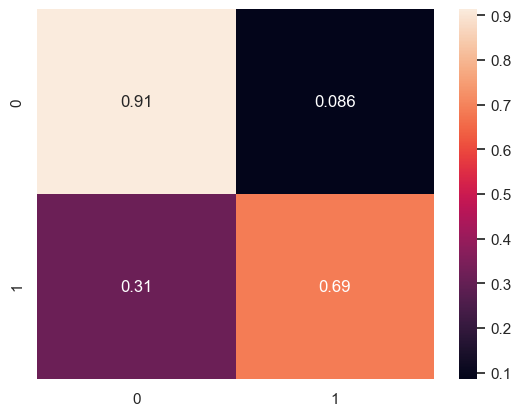

In [1050] used 0.0 MiB RAM in 0.29s (system mean cpu 20%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1016.0 MiB


In [1050]:
cf_matrix = metrics.confusion_matrix(y_test, y_pred, normalize='true')
sns.heatmap(cf_matrix, annot=True)
#if it's a “1”, the passenger survived. if it's a “0”, the passenger died.
# Ordonnée : classe réelle
# Abscisse : classe prédite

ROC AUC: 0.86


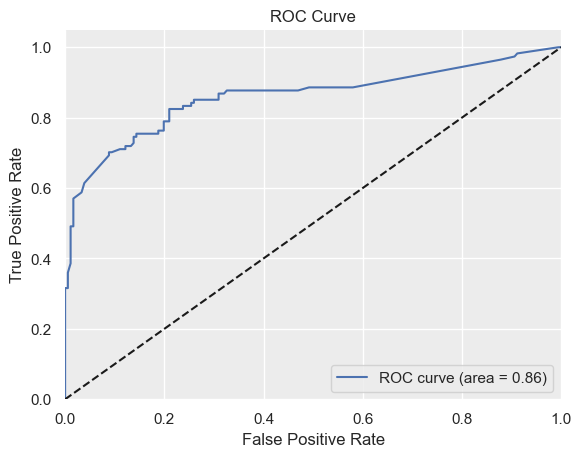

In [1051] used 0.0 MiB RAM in 0.30s (system mean cpu 22%, single max cpu 100%), peaked 0.0 MiB above final usage, current RAM usage now 1016.0 MiB


In [1051]:
# Determine les taux de faux et vrais positifs
#y_testDF = # ground truth labels
#y_proba = # predicted probabilities generated by sklearn classifier
fpr1, tpr1, s1 = metrics.roc_curve(y_testDF, y_proba[:, 1])

# Calcul de l'AUC
roc_auc1 = metrics.auc(fpr1, tpr1)
print('ROC AUC: %0.2f' % roc_auc1)
 
# Affiche sous forme de courbe
plt.figure()
plt.plot(fpr1, tpr1, label='ROC curve (area = %0.2f)' % roc_auc1)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()